In [2]:
from functions import *

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from multiprocessing import Pool, cpu_count

# high quality figures 
plt.rcParams['figure.dpi'] = 200  # Higher DPI for better quality
plt.rcParams['figure.figsize'] = [3.5, 3.5]  # Smaller physical size but still high quality

## **Modelling the Flache and Macy Model**

### **Initializing the Network**

Let's see what the caveman network looks like. Observe that there are 20 groups of 5 nodes each.

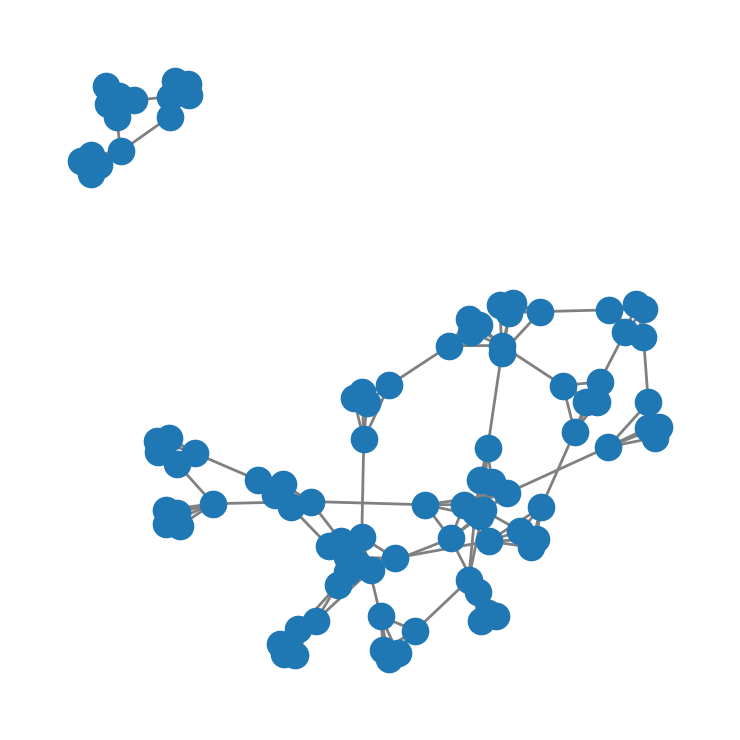

In [2]:
n_caves = 20  # number of groups 
n_members = 5   # number of nodes in each group

# create a cave-man network with 20 nodes in groups of 5
G = nx.connected_caveman_graph(n_caves, n_members)
G = initialize_network(n_caves, n_members, add_random_ties=True, p_random=0.003)

# pos = nx.spring_layout(G)
nx.draw(G, with_labels=False, node_size=80, edge_color='gray')
plt.show()

### **Simulating the Model**

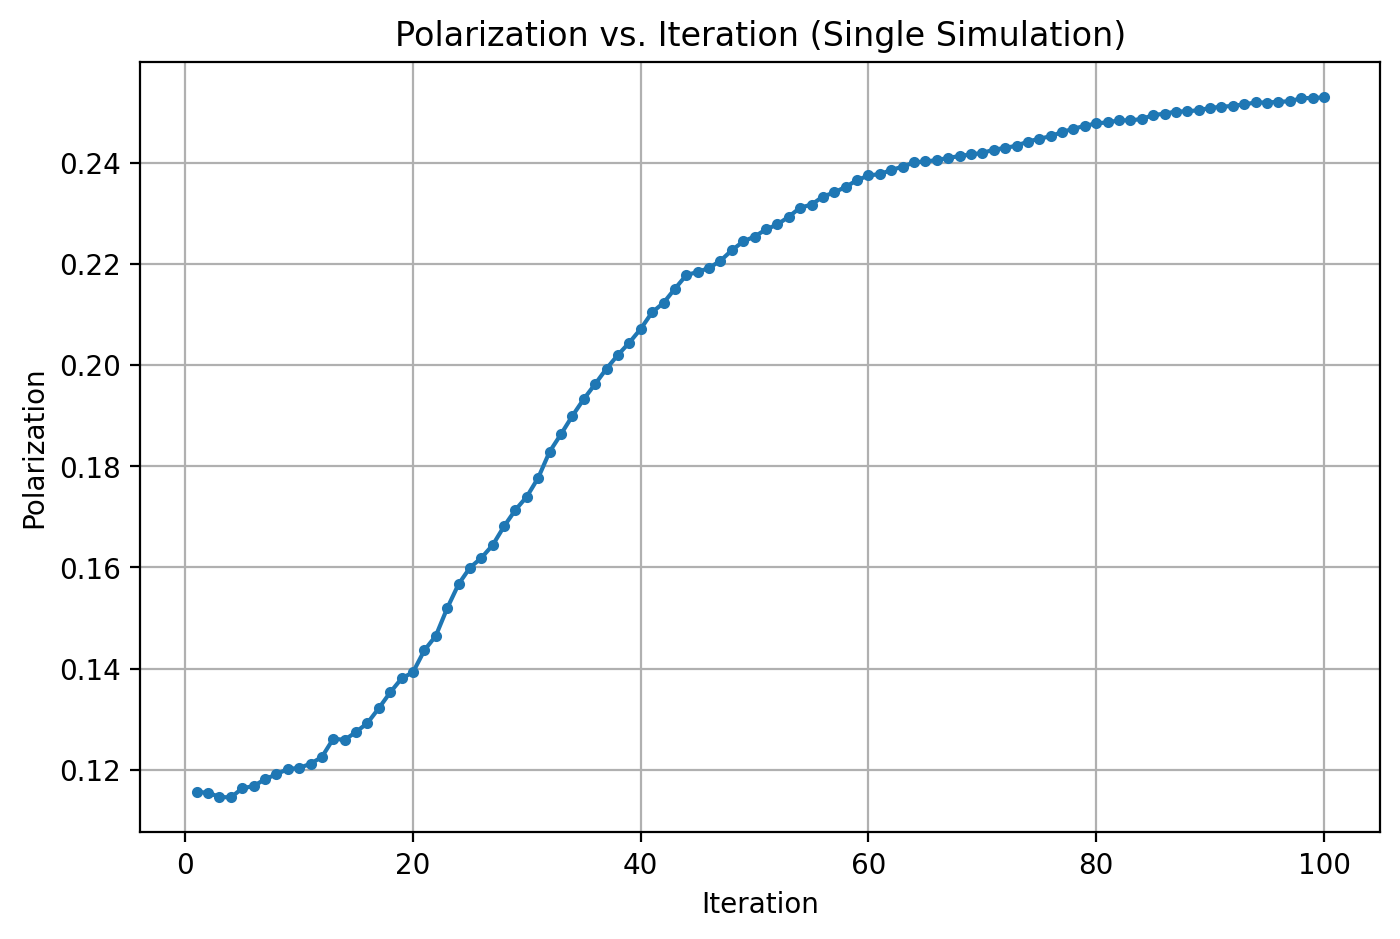

In [3]:
# Set simulation parameters
N = 100
num_caves = 20
cave_size = 5   # (so that N = num_caves * cave_size)
K = 2           # Number of opinion dimensions
num_iterations = 100  # Each iteration = N time steps

# Initialize the network (caveman graph without extra random ties for this example)
G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.003)

# Initialize the opinion matrix S and weight matrix W (using the base FM model assumptions)
S = initialize_opinions(N, K)
W = compute_weights(S)

# Run the simulation for the specified number of iterations
polarization_history, S_final, W_final = run_simulation(G, S, W, num_iterations)

# Plot polarization vs. iteration number
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_iterations + 1), polarization_history, marker='.')
plt.xlabel("Iteration")
plt.ylabel("Polarization")
plt.title("Polarization vs. Iteration (Single Simulation)")
plt.grid(True)
plt.show()

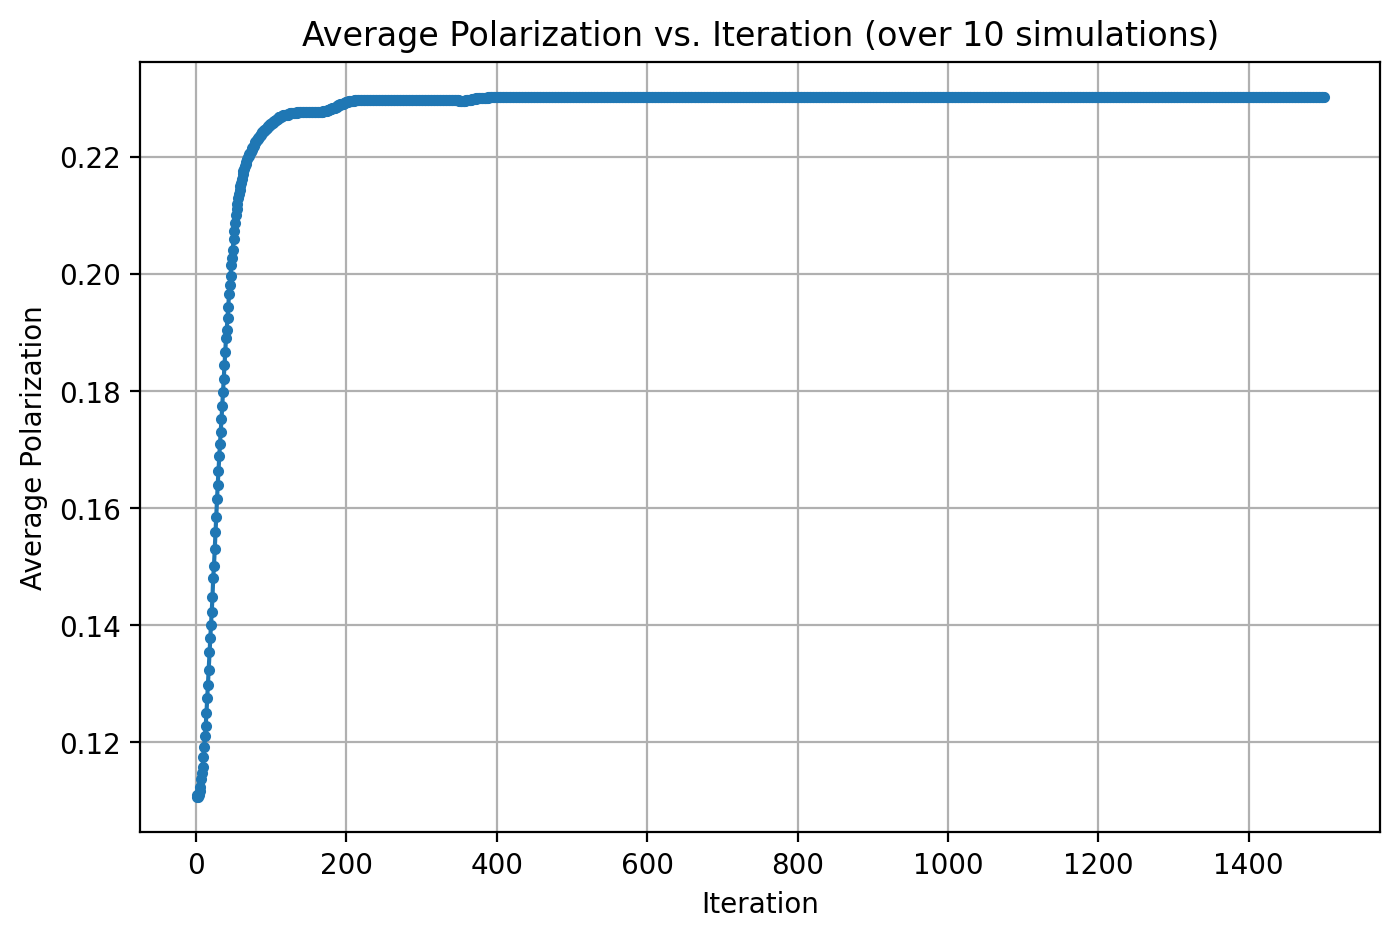

In [ ]:
Nsims = 10  # Number of independent simulations
all_polarizations = []  # To store polarization histories for each simulation

# For each simulation, we reinitialize opinions (and weights) but use the same network G.
for sim in range(Nsims):
    S_sim = initialize_opinions(N, K)        # Reinitialize opinions
    W_sim = compute_weights(S_sim)           # Compute initial weights based on S_sim
    
    # Run simulation for this replicate
    pol_history, S_final, W_final = run_simulation(G, S_sim, W_sim, 1500)
    all_polarizations.append(pol_history)

# Convert to numpy array: shape (Nsims, num_iterations)
all_polarizations = np.array(all_polarizations)

# Compute the average polarization at each iteration across simulations
avg_polarization = np.mean(all_polarizations, axis=0)

# Plot average polarization vs. iteration number
plt.figure(figsize=(8, 5))
plt.plot(range(1, 1500 + 1), avg_polarization, marker='.')
plt.xlabel("Iteration")
plt.ylabel("Average Polarization")
plt.title("Average Polarization vs. Iteration (over {} simulations)".format(Nsims))
plt.grid(True)
plt.show()

### **Model without Negative Valence**

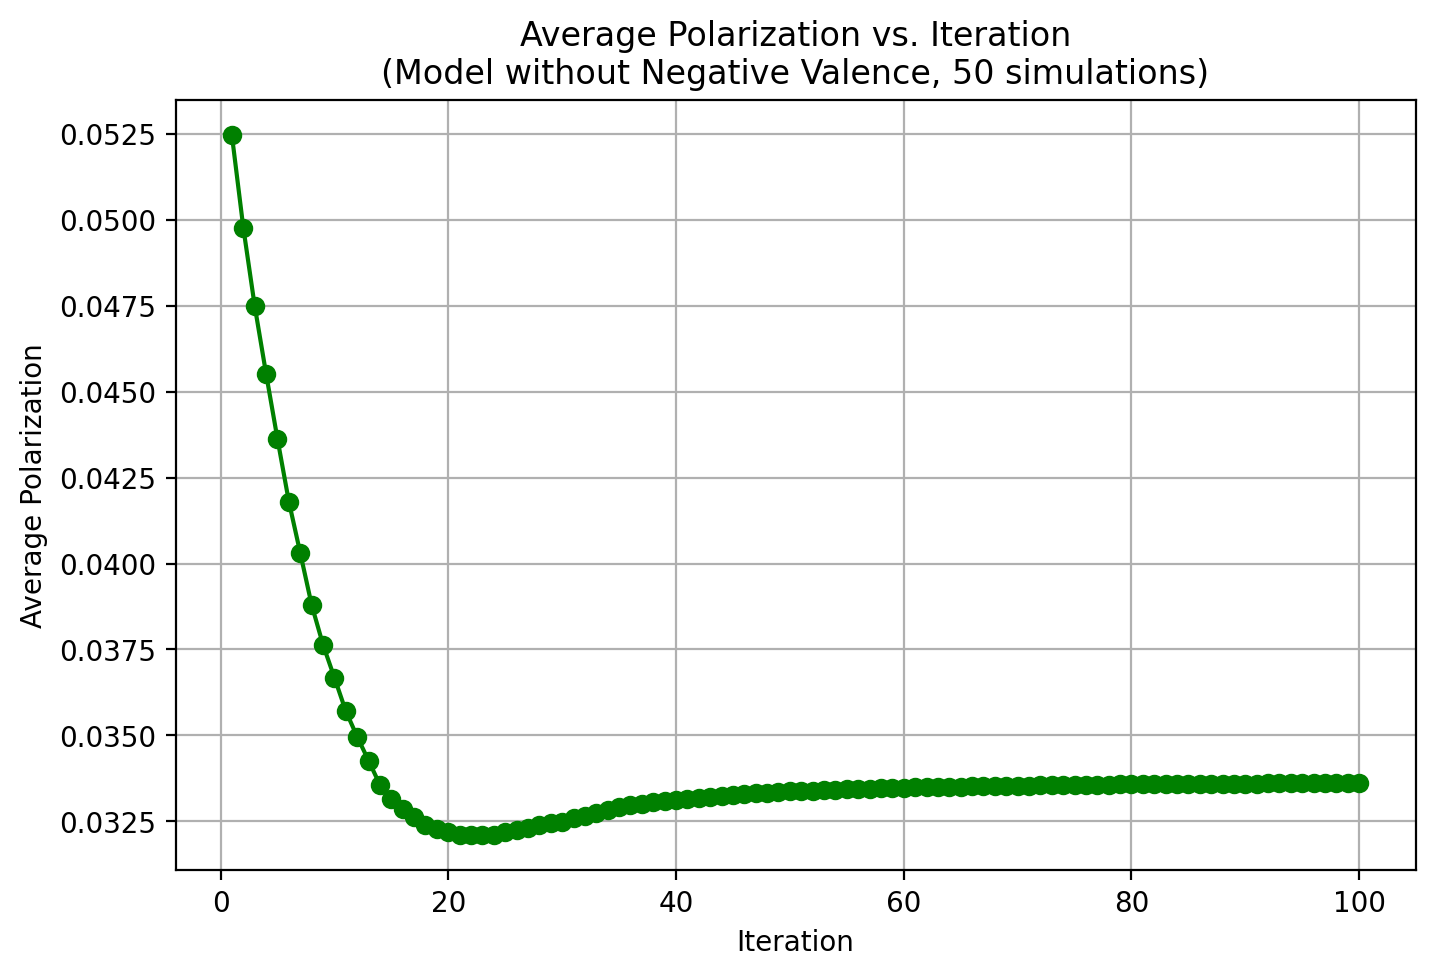

In [2]:
num_caves = 20
cave_size = 5        # Thus, N = 20 * 5 = 100 agents.
N = num_caves * cave_size
K = 2                # Two opinion dimensions.
num_iterations = 100 # Each iteration = 100 time steps.
Nsims = 50           # Run 50 independent simulations.
allow_negative = False  # Model without negative valence of interaction.

# Initialize the network (here, we do not add extra random ties)
G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.03)

# Container for polarization histories from each simulation
all_polarizations = []

for sim in range(Nsims):
    # Reinitialize opinions and weights for each simulation
    S_sim = initialize_opinions(N, K)
    W_sim = compute_weights(S_sim, allow_negative=allow_negative)
    
    # Run the simulation for num_iterations iterations
    pol_history, S_final, W_final = run_simulation(G, S_sim, W_sim, num_iterations, allow_negative=allow_negative)
    all_polarizations.append(pol_history)

all_polarizations = np.array(all_polarizations)  # Shape: (Nsims, num_iterations)
avg_polarization = np.mean(all_polarizations, axis=0)

# Plot average polarization vs. iteration
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_iterations + 1), avg_polarization, marker='o', color='green')
plt.xlabel("Iteration")
plt.ylabel("Average Polarization")
plt.title("Average Polarization vs. Iteration\n(Model without Negative Valence, {} simulations)".format(Nsims))
plt.grid(True)
plt.show()

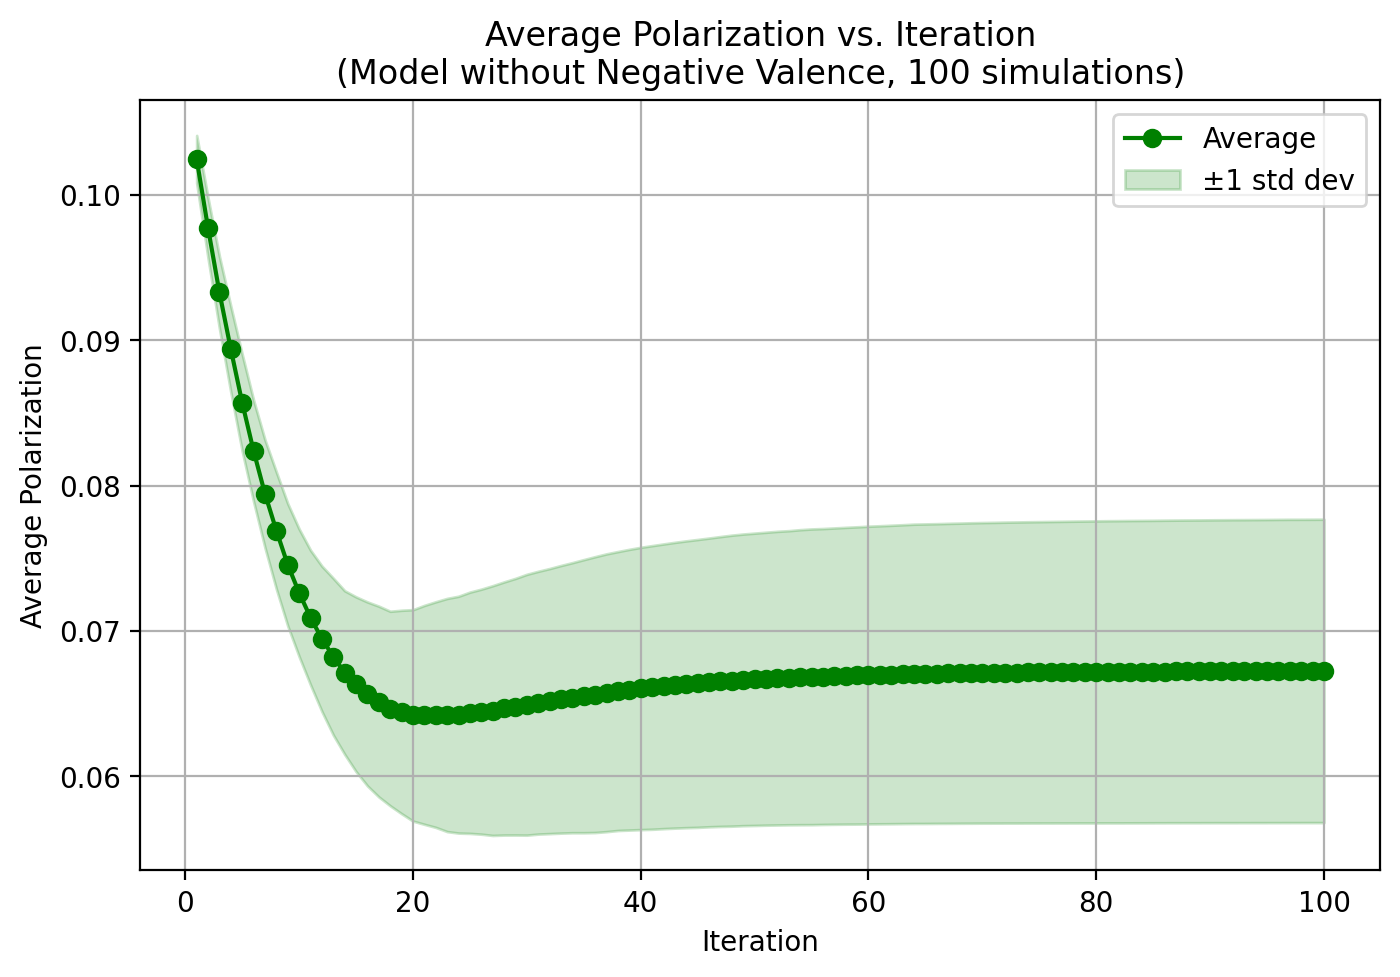

In [4]:
num_caves = 20
cave_size = 5        # Thus, N = 20 * 5 = 100 agents.
N = num_caves * cave_size
K = 2                # Two opinion dimensions.
num_iterations = 100 # Each iteration = 100 time steps.
Nsims = 100           # Run 50 independent simulations.
allow_negative = False  # Model without negative valence of interaction.

# Initialize the network (here, we do not add extra random ties)
G = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.03)

# Container for polarization histories from each simulation
all_polarizations = []

def run_single_simulation(sim):
    # Reinitialize opinions and weights for each simulation
    S_sim = initialize_opinions(N, K)
    W_sim = compute_weights(S_sim, allow_negative=allow_negative)
    
    # Run the simulation for num_iterations iterations
    pol_history, S_final, W_final = run_simulation(G, S_sim, W_sim, num_iterations, allow_negative=allow_negative)
    return pol_history

# Use all available CPU cores
with Pool(cpu_count()) as pool:
    all_polarizations.extend(pool.map(run_single_simulation, range(Nsims)))

all_polarizations = np.array(all_polarizations)  # Shape: (Nsims, num_iterations)
avg_polarization = np.mean(all_polarizations, axis=0)
std_polarization = np.std(all_polarizations, axis=0)

# Plot average polarization vs. iteration with confidence interval
plt.figure(figsize=(8, 5))
x = range(1, num_iterations + 1)
plt.plot(x, avg_polarization, marker='o', color='green', label='Average')
plt.fill_between(x, 
                avg_polarization - std_polarization,
                avg_polarization + std_polarization,
                color='green', alpha=0.2, label='±1 std dev')
plt.xlabel("Iteration")
plt.ylabel("Average Polarization")
plt.title("Average Polarization vs. Iteration\n(Model without Negative Valence, {} simulations)".format(Nsims))
plt.grid(True)
plt.legend()
plt.show()

In [3]:
# PARAMETERS
num_caves = 20
cave_size = 5         # Total agents: N = num_caves * cave_size = 100
N = num_caves * cave_size
K = 2                 # Number of opinion dimensions
num_iterations = 100  # Number of iterations (each iteration = N time steps)
Nsims = 100           # Number of simulation runs for each condition
allow_negative = False

# p for adding random ties when they are added either at initialization or later:
p_random_initial = 0.03   # Condition 3: ties at initialization
p_random_later = 0.03     # Condition 2: ties added after iteration 50

# We'll store the average polarization history (an array of length num_iterations) for each condition.
all_avg_pol = {}

# ---------- Condition 1: Disconnected Caveman Graph ----------
# No random ties added either at initialization or later.
pol_histories_cond1 = []

def run_single_sim_cond1(_):  # Add parameter to accept the iteration number (unused)
    # Create a disconnected caveman graph
    G1 = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.003)
    # Initialize opinions and weights
    S1 = initialize_opinions(N, K)
    W1 = compute_weights(S1, allow_negative=allow_negative)
    
    # Run simulation with no additional tie injection (tie_addition_iter = None)
    pol_history, S1_final, W1_final = run_simulation(G1, S1, W1, num_iterations,
                                                    allow_negative=allow_negative,
                                                    tie_addition_iter=None,
                                                    p_random_new=None)
    return pol_history

# Use all available CPU cores
with Pool(cpu_count()) as pool:
    pol_histories_cond1.extend(pool.map(run_single_sim_cond1, range(Nsims)))

# Average over runs (axis=0 gives an average for each iteration)
pol_histories_cond1 = np.array(pol_histories_cond1)
avg_pol_cond1 = np.mean(pol_histories_cond1, axis=0)
all_avg_pol['Disconnected'] = avg_pol_cond1

print("Done with Condition 1")

# ---------- Condition 2: Disconnected Graph with Ties Added at Iteration 50 ----------
# Start with a disconnected caveman graph; then, after iteration 50, add random ties with p=0.03.
pol_histories_cond2 = []

def run_single_sim_cond2(_):  # Add parameter to accept the iteration number (unused)
    G2 = initialize_network(num_caves, cave_size, add_random_ties=False, p_random=0.003)
    S2 = initialize_opinions(N, K)
    W2 = compute_weights(S2, allow_negative=allow_negative)
    
    # Here we specify tie_addition_iter=50, so that after 50 iterations new ties are added.
    pol_history, S2_final, W2_final = run_simulation(G2, S2, W2, num_iterations,
                                                     allow_negative=allow_negative,
                                                     tie_addition_iter=50, 
                                                     p_random_new=p_random_later)
    return pol_history

# Use all available CPU cores
with Pool(cpu_count()) as pool:
    pol_histories_cond2.extend(pool.map(run_single_sim_cond2, range(Nsims)))

# Average over runs (axis=0 gives an average for each iteration)
pol_histories_cond2 = np.array(pol_histories_cond2)
avg_pol_cond2 = np.mean(pol_histories_cond2, axis=0)
all_avg_pol['Delayed Ties (iter=50)'] = avg_pol_cond2

print("Done with Condition 2")

# ---------- Condition 3: Caveman Graph with Random Ties at Initialization ----------
# Create a caveman graph that already has random ties (with p=0.03) at the outset.
pol_histories_cond3 = []

def run_single_sim_cond3(_):  # Add parameter to accept the iteration number (unused)
    G3 = initialize_network(num_caves, cave_size, add_random_ties=True, p_random=p_random_initial)
    S3 = initialize_opinions(N, K)
    W3 = compute_weights(S3, allow_negative=allow_negative)
    
    # Run simulation with no later tie addition.
    pol_history, S3_final, W3_final = run_simulation(G3, S3, W3, num_iterations,
                                                     allow_negative=allow_negative,
                                                     tie_addition_iter=None,
                                                     p_random_new=None)
    return pol_history

# Use all available CPU cores
with Pool(cpu_count()) as pool:
    pol_histories_cond3.extend(pool.map(run_single_sim_cond3, range(Nsims)))

pol_histories_cond3 = np.array(pol_histories_cond3)
avg_pol_cond3 = np.mean(pol_histories_cond3, axis=0)
all_avg_pol['Initial Ties'] = avg_pol_cond3

print("Done with Condition 3")

Done with Condition 1
Done with Condition 2
Done with Condition 3


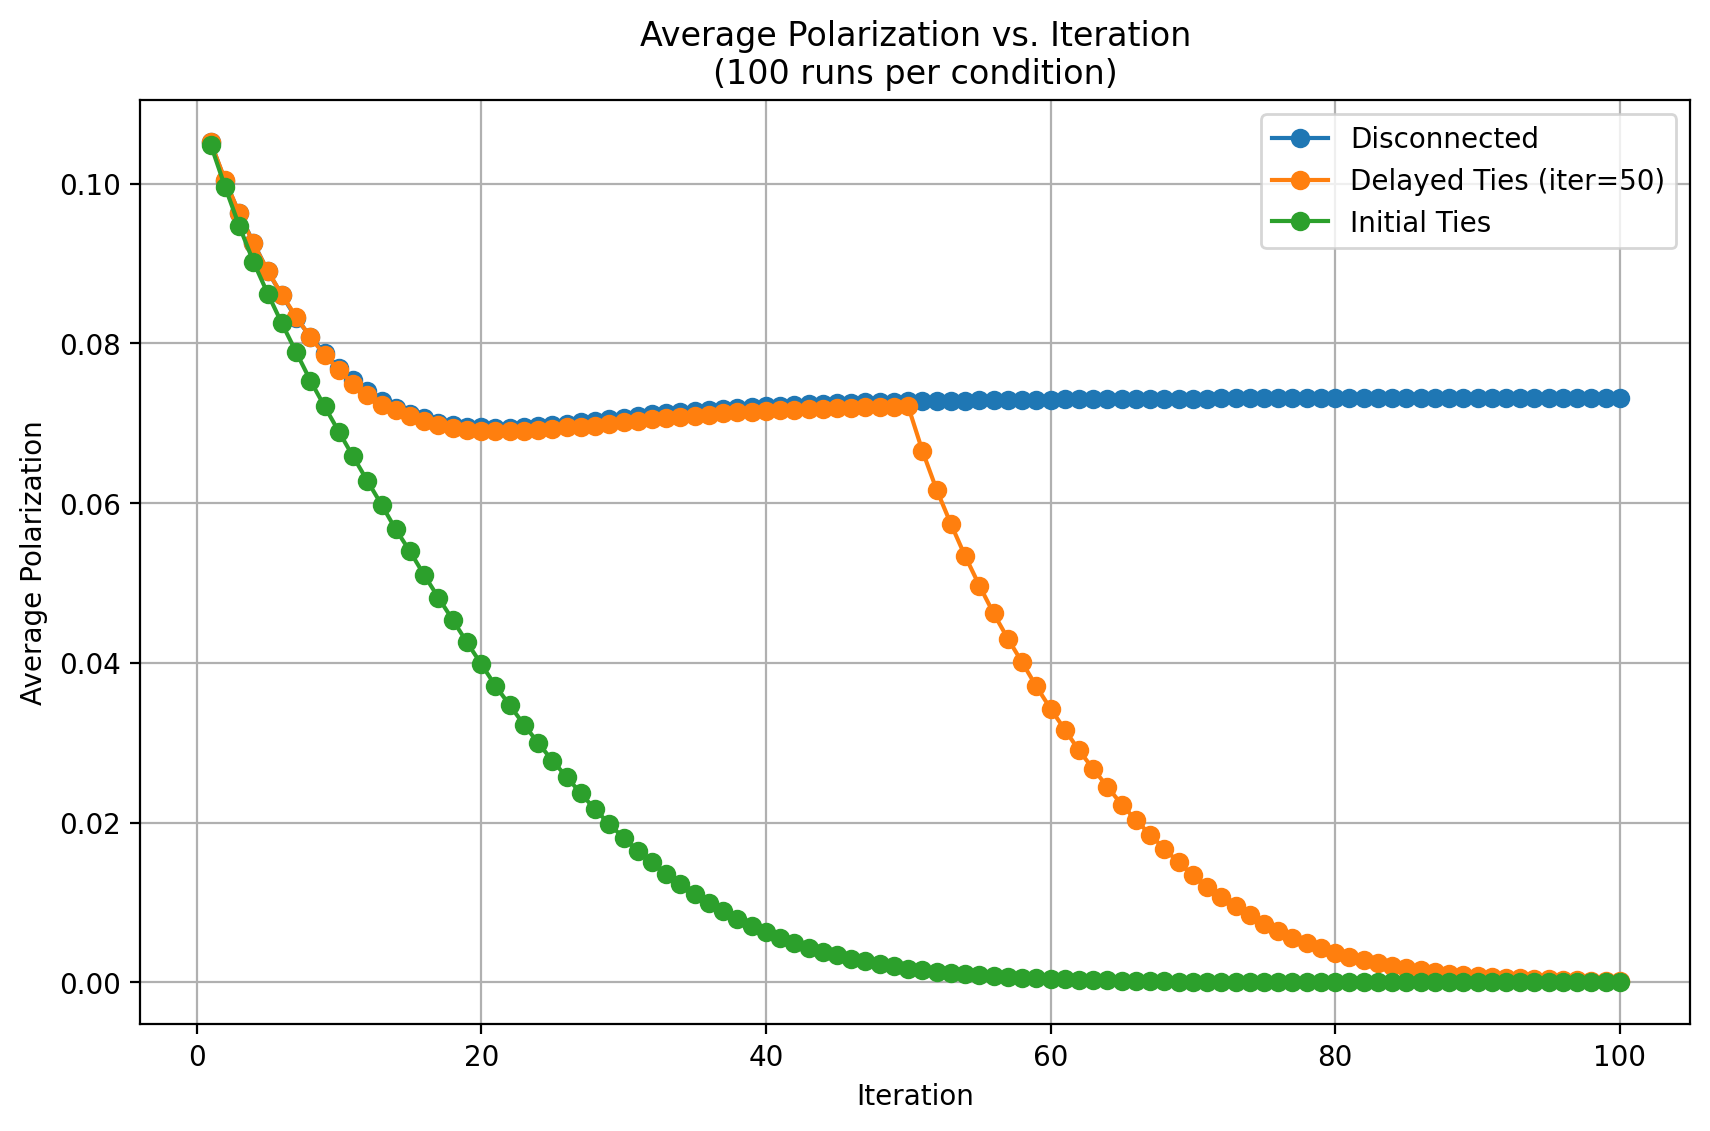

In [4]:
# ---------- Plotting ----------
plt.figure(figsize=(10, 6))
iterations = np.arange(1, num_iterations+1)

for label, avg_pol in all_avg_pol.items():
    plt.plot(iterations, avg_pol, marker='o', label=label)

plt.xlabel("Iteration")
plt.ylabel("Average Polarization")
plt.title("Average Polarization vs. Iteration\n(100 runs per condition)")
plt.legend()
plt.grid(True)
plt.show()